In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as trans
from torch import nn
from torch import optim
from IPython.display import clear_output
from torch.utils.data import random_split
from torchsummary import summary

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
train = datasets.FashionMNIST(root='./data', train=True, download=True, transform=trans.ToTensor())

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.8MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 203kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.84MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 5.92MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
test = datasets.FashionMNIST(root='./data', train=False, transform=trans.ToTensor())

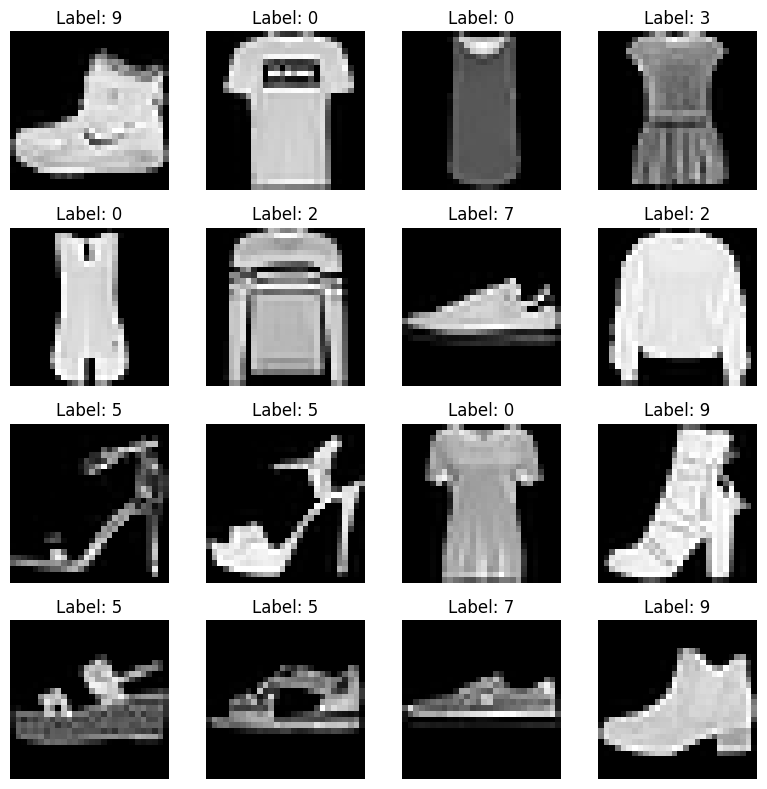

In [ ]:
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
for i in range(4):
    for j in range(4):
        image, label = train[i * 4 + j]
        image_numpy = image.numpy().squeeze()
        axs[i, j].imshow(image_numpy, cmap='gray')
        axs[i, j].axis('off')
        axs[i, j].set_title(f"Label: {label}")
plt.tight_layout()
plt.show()

In [ ]:
train_set, valid = random_split(train, (0.95, 0.05))

In [ ]:
model = nn.Sequential(
    nn.Flatten(start_dim=-3),
    nn.Linear(in_features=784, out_features=1500),
    nn.BatchNorm1d(1500),
    nn.ReLU(),
    nn.Linear(in_features=1500, out_features=888),
    nn.BatchNorm1d(888),
    nn.Sigmoid(),
    nn.Linear(in_features=888, out_features=100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Linear(in_features=100, out_features=10),
)

In [ ]:
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 1500]       1,177,500
       BatchNorm1d-3                 [-1, 1500]           3,000
              ReLU-4                 [-1, 1500]               0
            Linear-5                  [-1, 888]       1,332,888
       BatchNorm1d-6                  [-1, 888]           1,776
           Sigmoid-7                  [-1, 888]               0
            Linear-8                  [-1, 100]          88,900
       BatchNorm1d-9                  [-1, 100]             200
             ReLU-10                  [-1, 100]               0
           Linear-11                   [-1, 10]           1,010
Total params: 2,605,274
Trainable params: 2,605,274
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

In [ ]:
loss = nn.CrossEntropyLoss()

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=1e-3)

In [ ]:
def run(model, dataloader, loss_function, optimizer = None):
  if optimizer == None:
    model.eval()
  else:
    model.train()
  total = 0
  for x, y in dataloader:
    pred = model(x)
    loss = loss_function(pred, y)
    total += loss.item()
    if optimizer != None:
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
  return total / len(dataloader)

In [ ]:
from IPython.display import clear_output

def show_losses(train_loss_hist, test_loss_hist):
    clear_output()

    plt.figure(figsize=(12,4))

    plt.subplot(1, 2, 1)
    plt.title('Train Loss')
    plt.plot(np.arange(len(train_loss_hist)), train_loss_hist)
    plt.yscale('log')
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.title('Test Loss')
    plt.plot(np.arange(len(test_loss_hist)), test_loss_hist)
    plt.yscale('log')
    plt.grid()

    plt.show()

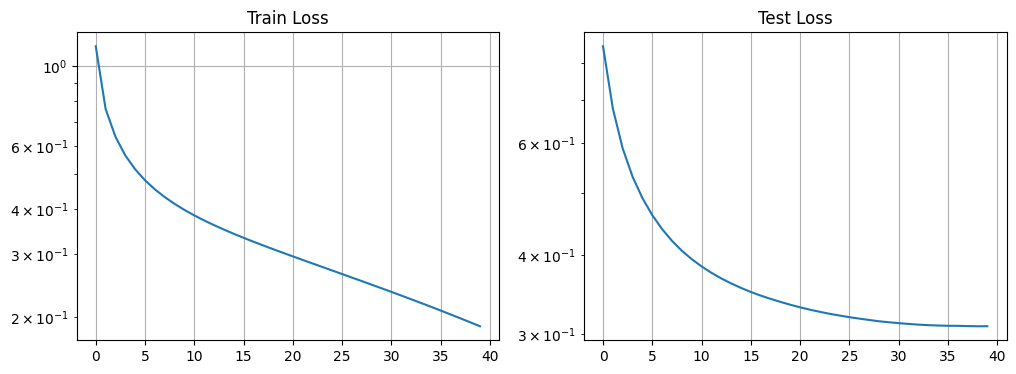

Best Epochs:  38


In [ ]:
Batch = 100
Epochs = 100

train_loader = DataLoader(train_set, batch_size=Batch)
valid_loader = DataLoader(valid, batch_size=Batch)

train_loss_hist = []
test_loss_hist = []
prev_loss = 10 ** 9

for i in range(Epochs):
    train_loss = run(model, train_loader, loss, optimizer)
    train_loss_hist.append(train_loss)
    test_loss = run(model, valid_loader, loss)
    test_loss_hist.append(test_loss)
    if i % 1 == 0:
        show_losses(train_loss_hist, test_loss_hist)
    if prev_loss < test_loss:
      print("Best Epochs: ", i - 1)
      break
    else:
      prev_loss = test_loss

In [ ]:
test_loader = DataLoader(test, batch_size=Batch)

In [ ]:
test_loss = run(model, test_loader, loss)
test_loss

0.33240177765488627

In [ ]:
def accuracy(model, dataloader, loss_function, optimizer=None):
    if optimizer == None:
        model.eval()
    else:
        model.train()

    cnt = 0
    all = 0

    for X, y in dataloader:
        pred = model(X)
        for i in range(len(y)):
          x1 = -10 ** 9
          num = -1
          for j in range(len(pred[i])):
            if pred[i][j] > x1:
              x1 = pred[i][j]
              num = j
          y1 = y[i]
          if num == y1:
            cnt+=1
          all+=1

    accuracy = cnt / all
    return accuracy

In [ ]:
acc = accuracy(model, test_loader, loss)
acc

0.8857

In [ ]:
from sklearn.metrics import precision_score, recall_score

In [ ]:
def prep_metrics(model, dataloader):
  model.eval()
  true = []
  pred = []

  for x, y in dataloader:
    pred_y = model(x)
    _, predicted = torch.max(pred_y.data, 1)
    true.extend(y.cpu().numpy())
    pred.extend(predicted.cpu().numpy())
  return precision_score(true, pred, average='weighted'), recall_score(true, pred, average='weighted')

In [ ]:
precision, recall = prep_metrics(model, test_loader)

In [ ]:
precision

0.8868129962533083

In [ ]:
recall

0.8857

In [ ]:
(2 * precision * recall) / (precision + recall)

0.8862561486903843

ВЫВОД:

Можно заметить, что модель в принципе имеет достаточно хорошую точность, и достаточно не высокий loss, учитывая, что она еще не использует свертки. В принципе структуру можно оставить и добавить туда сверток.